# Duck DB Exploration with FitBit Data
The purpose of this notebook is to explore the versatility of [DuckDB](https://duckdb.org/) while exploring my data from my Fitbit. If you [download your data from fitbit](https://takeout.google.com/settings/takeout/custom/fitbit) you will end up with a zipped file with many directories and a mix of JSON files and CSV files. Building a custom parser to get this data and organize it properly can be time consuming, especially since the JSON files have some deep nesting. Instead what we can do is have DuckDB read in these JSON files, execute SQL against them and then merge data together to explore it. My end goal for this exploration is to create a model to predict my HRV, so what I am going to need is data on my HRV, and I'm also going to bring in my sleep data and my daily heart rate data to see if there are good predictors there. I am fully aware that the HRV is likely not accurate on my Fitbit, but let's have some fun anyway! I will not be building models or building visualizations in this notebook, I will save that for another notebook.

## Getting Started
Before we get going, just a little explanation of the data. Different versions of Fitbits will likely have different sensors and therefore different data. I haven't done any research to know if the directories are the same and I am not really concerned about that. I have a Charge 5 and I have noticed that there is a TON more data here than the application shows you. We have a lots of directories and data, let's take a look at how many files we have and what types. **Note: when I was developing this I used the ***.show()*** function for displaying results directly from DuckDB. This did a really good job displaying nested data in a tabular format, but the display looked terrible on the HTML export of the Jupyter Notebook, so I converted everything to a dataframe and displayed that instead, but the show function works just fine in jupyter, just not the export.**

In [1]:
import pandas as pd
import os
from collections import defaultdict

def list_directories_and_count_files_by_type_with_summary(root_dir):
    overall_file_type_counts = defaultdict(int)  # To store the overall summary
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        file_type_counts = defaultdict(int)
        
        for filename in filenames:
            file_extension = os.path.splitext(filename)[1].lower()  # Get the file extension
            file_type_counts[file_extension] += 1
            overall_file_type_counts[file_extension] += 1  # Add to overall summary
        
        print(f"Directory: {dirpath}")
        for file_type, count in file_type_counts.items():
            print(f"  {file_type if file_type else '[No Extension]'}: {count}")
        print("-" * 40)
    
    # Print the overall summary
    print("Summary of all file types across all directories:")
    for file_type, total_count in overall_file_type_counts.items():
        print(f"  {file_type if file_type else '[No Extension]'}: {total_count}")
    print("-" * 40)

root_directory = './data/unzipped/Takeout'
list_directories_and_count_files_by_type_with_summary(root_directory)

Directory: ./data/unzipped/Takeout
  .html: 1
----------------------------------------
Directory: ./data/unzipped/Takeout\Fitbit
----------------------------------------
Directory: ./data/unzipped/Takeout\Fitbit\Account Changes
  .csv: 1
----------------------------------------
Directory: ./data/unzipped/Takeout\Fitbit\Active Zone Minutes (AZM)
  .csv: 16
----------------------------------------
Directory: ./data/unzipped/Takeout\Fitbit\Activity Goals
  .txt: 1
  .csv: 1
----------------------------------------
Directory: ./data/unzipped/Takeout\Fitbit\Atrial Fibrillation ECG
  .csv: 6
  .txt: 1
----------------------------------------
Directory: ./data/unzipped/Takeout\Fitbit\Biometrics
  .txt: 1
  .csv: 210
----------------------------------------
Directory: ./data/unzipped/Takeout\Fitbit\Daily Readiness
  .txt: 1
  .csv: 15
----------------------------------------
Directory: ./data/unzipped/Takeout\Fitbit\Discover
  .txt: 1
----------------------------------------
Directory: ./data/

That is a lot of files, they're not very big but each style of file likely has it's own way of storing stuff. If it's not a CSV it's going to be annoying to get what we need. In addition to that, if we wanted to write SQL against it, loading data into a database like PostgreSQL would be annoyingly time consuming to setup, especially if our goal is to explore and analyze the data and not necessarily create an application out of it. We just want to organize the data well using simple SQL syntax and then get what we need for our analysis and that's what **DuckDB** is going to help us with. Okay enough chatting let's do something. 

## DuckDB - Getting Started
These few lines of code are all we need to load our sleep data. First we import the library, then we make a connection, you don't have to supply a string argument which creates a permanent database. If you don't supply an argument it's like having a temp database, all the rest of the commands in the notebook will work. I did it because later, I will want to store some data in a table, but for now it's not necessary. Finally the 3rd line is where we get a lot of help, we are going to read in all of the JSON files in the *Global Export Data* directory that begin with "sleep-". **DuckDB** will read the json data and store it in the sleep_data relation (what **DuckDB** uses).

In [2]:
import duckdb
conn = duckdb.connect('./data/fitbit_db.duckdb') # creates a database
sleep_data = duckdb.read_json("./data/unzipped/Takeout/Fitbit/Global Export Data/sleep-*.json")
print(f'The object type for sleep_data is {type(sleep_data)}') 

The object type for sleep_data is <class 'duckdb.duckdb.DuckDBPyRelation'>


This did a pretty good job of reading in the data, it parsed the **dateOfSleep** properly and got the **mainSleep** as a *boolean* instead of a *varchar* which is pretty nice. Some more interesting points is that the **levels** field has a datatype of *struct* and inside we see all the nested JSON data. The first section is called **summary** which holds aggregate information about my different stages of sleep (deep, wake, light, & rem). It also has a bunch of NULL features tacked on to the end. After **summary** we have an array of **data** which shows the chronological sequence of each sleep stage and it's duration in seconds. There's also an array of data called **shortData** which contains small blips of time in chronological order. That makes sense because when I look at the *Sleep Timeline* section on the Fitbit app there are often short small bursts of time in the Awake section. This is likely the data that is displayed there.

Let's reimport the data and convert those timestamps so that we can use this data properly.

In [3]:
sleep_data = duckdb.read_json("./data/unzipped/Takeout/Fitbit/Global Export Data/sleep-*.json", timestamp_format="%Y-%m-%dT%H:%M:%S.%g")
display(sleep_data.df().head(5))

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency,type,infoCode,logType,levels,mainSleep
0,42724299942,2023-09-10,2023-09-09 21:34:00,2023-09-10 06:11:00,31020000,0,457,60,0,517,98,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 1...",True
1,42712673606,2023-09-09,2023-09-08 22:14:00,2023-09-09 05:37:30,26580000,0,400,43,0,443,100,stages,0,auto_detected,"{'summary': {'deep': {'count': 4, 'minutes': 6...",True
2,42703109427,2023-09-08,2023-09-07 21:48:00,2023-09-08 05:23:30,27300000,0,398,57,0,455,99,stages,0,auto_detected,"{'summary': {'deep': {'count': 6, 'minutes': 7...",True
3,42688951099,2023-09-07,2023-09-06 21:58:00,2023-09-07 05:46:30,28080000,0,413,55,1,468,98,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 8...",True
4,42676589452,2023-09-06,2023-09-05 22:10:30,2023-09-06 05:37:00,26760000,0,376,70,10,446,96,stages,0,auto_detected,"{'summary': {'deep': {'count': 3, 'minutes': 8...",True


That was really easy and fast, what I'd like to do now is explore this dataset a bit. The goal here is to show simple ways to access and point out some interesting features. First you can describe the data, similar to what you are able to do with pandas.

In [4]:
sleep_data.describe().df()

,aggr,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency,type,infoCode,logType,levels,mainSleep
0,count,4.810000e+02,481,481,481,4.810000e+02,481.0,481.000000,481.000000,481.000000,481.000000,481.000000,481,481.000000,481,481,481
1,mean,4.506723e+10,None,None,None,2.732532e+07,0.0,406.800416,48.496881,0.557173,455.422037,98.168399,None,0.008316,None,None,None
2,stddev,1.513614e+09,None,None,None,3.387921e+06,0.0,52.882236,11.543419,1.348361,56.465353,1.677895,None,0.128831,None,None,None
3,min,4.240092e+10,2023-08-13,2023-08-12 22:16:00,2023-08-13 05:54:30,5.460000e+06,0.0,82.000000,1.000000,0.000000,91.000000,88.000000,classic,0.000000,auto_detected,"{'summary': {'deep': {'count': 1, 'minutes': 4...",false
4,max,4.759902e+10,2024-11-27,2024-11-26 22:39:00,2024-11-27 04:01:30,3.558000e+07,0.0,543.000000,90.000000,10.000000,593.000000,100.000000,stages,2.000000,auto_detected,"{'summary': {'deep': NULL, 'wake': NULL, 'ligh...",true
5,median,4.511957e+10,None,None,None,2.748000e+07,0.0,410.000000,48.000000,0.000000,458.000000,99.000000,None,0.000000,None,None,None


I can see that I have 481 entries in this dataset, but from the **dateOfSleep** data I'm not convinced I have 1 record for every night as the date difference between 2023-08-13 and 2024-11-27 is 471 days not 481. I also know that some nights I probably forgot to wear my fitbit so I know the number should be even less than 471. I can also see that some columns aren't going to be very useful to me, like **minutesToFallAsleep** has no mean or stddev so it never changes from 0, similarly **logType** has the same 'auto_detected' value. Let's write some SQL to take a look at the data and see what's up.

In [5]:
display(duckdb.sql("SELECT dateOfSleep, count(*) as count FROM sleep_data GROUP BY dateOfSleep Having count(*) > 1").df())
display(duckdb.sql("select count(distinct dateOfSleep) as distinct_dates from sleep_data").df())

,dateOfSleep,count
0,2023-11-09,2
1,2024-07-06,2
2,2023-10-10,2
3,2023-09-10,2
4,2024-03-08,2
5,2024-05-07,2
6,2024-08-05,2
7,2024-06-06,2
8,2024-10-04,2
9,2024-01-08,2


,distinct_dates
0,465


I was right 465 unique dates, but 481 rows so I have some duplicates for some days...something is funky with that data. Before I work on that I just wanted to point out what **DuckDB** was able to do for us, our 'table' is the object that we read in. We can easily write SQL syntax against files or anything we read in just by using it like we would a table in SQL...pretty cool.

Now I want to take a look at the data from those duplicate dates, SQL syntax to the rescue!

In [6]:
display(duckdb.sql("""SELECT s.* from sleep_data s where dateOfSleep in 
            (SELECT dateOfSleep FROM sleep_data GROUP BY dateOfSleep Having count(*) > 1) 
           order by dateOfSleep""").df())
display(duckdb.sql("""SELECT s.logId, unnest(levels.summary.deep) from sleep_data s where dateOfSleep in 
            (SELECT dateOfSleep FROM sleep_data GROUP BY dateOfSleep Having count(*) > 1) 
           order by dateOfSleep""").df())

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency,type,infoCode,logType,levels,mainSleep
0,42724299942,2023-09-10,2023-09-09 21:34:00,2023-09-10 06:11:00,31020000,0,457,60,0,517,98,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 1...",True
1,42724299942,2023-09-10,2023-09-09 21:34:00,2023-09-10 06:11:00,31020000,0,457,60,0,517,98,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 1...",True
2,43071124476,2023-10-10,2023-10-09 22:29:00,2023-10-10 05:40:30,25860000,0,384,47,0,431,99,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 8...",True
3,43071124476,2023-10-10,2023-10-09 22:29:00,2023-10-10 05:40:30,25860000,0,384,47,0,431,99,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 8...",True
4,43415888071,2023-11-09,2023-11-08 22:12:00,2023-11-09 05:32:30,26400000,0,399,41,1,440,98,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 6...",True
5,43415888071,2023-11-09,2023-11-08 22:12:00,2023-11-09 05:32:30,26400000,0,399,41,1,440,98,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 6...",True
6,43483210808,2023-11-14,2023-11-14 22:23:30,2023-11-14 23:55:00,5460000,0,82,9,0,91,90,classic,2,auto_detected,"{'summary': {'deep': None, 'wake': None, 'ligh...",False
7,43472303148,2023-11-14,2023-11-13 23:19:30,2023-11-14 06:01:30,24120000,0,362,40,7,402,98,stages,0,auto_detected,"{'summary': {'deep': {'count': 3, 'minutes': 6...",True
8,43758999257,2023-12-09,2023-12-08 21:45:30,2023-12-09 04:42:00,24960000,0,373,43,2,416,97,stages,0,auto_detected,"{'summary': {'deep': {'count': 3, 'minutes': 8...",True
9,43758999257,2023-12-09,2023-12-08 21:45:30,2023-12-09 04:42:00,24960000,0,373,43,2,416,97,stages,0,auto_detected,"{'summary': {'deep': {'count': 3, 'minutes': 8...",True


,logId,count,minutes,thirtyDayAvgMinutes
0,42724299942,5.0,104.0,0.0
1,42724299942,5.0,104.0,81.0
2,43071124476,5.0,87.0,80.0
3,43071124476,5.0,87.0,0.0
4,43415888071,5.0,67.0,88.0
5,43415888071,5.0,67.0,0.0
6,43483210808,NaN,NaN,NaN
7,43472303148,3.0,68.0,74.0
8,43758999257,3.0,80.0,77.0
9,43758999257,3.0,80.0,0.0


Very interesting, it looks like we have duplicates in the 'levels', specifically in the summary. The **thirtyDayAverageMinutes** seems to be miscomputed for some reason, we can handle this by flattening out the data structure. In addition it looks like we have just 1 record where the **mainSleep** was set to false (2023-11-14), but at least those records have different **logId** fields. 

One very helpful function I just ran shows how awesome **DuckDB** is, the *unnest* function can break down json data into it's individual parts. Depending on how the data is structured you can even refer to a lower level of data. In this case I was able to step into the **levels** field of data, into the **summary** subsection of **levels** and then grab one of the types of summaries for a sleep stage which was **deep** sleep and then flatten the data out. This is a very helpful and useful function when working with data and trying to reach important data nested in hierarchical structures.

What I'm going to do next is break up the data into different dataframes using **logId** as the key to link them all together, like setting up database tables with a link between them. I'll start with the outermost level of data, and for what I want to use this for, I don't need to look at sleep data that wasn't part of my main sleep.

In [7]:
sleep_meta_df = duckdb.sql("""Select distinct logId, dateOfSleep, startTime, endTime, duration, minutesToFallAsleep, minutesAsleep,
                            minutesAwake, minutesAfterWakeup, timeInBed, efficiency, type, infoCode, logType, mainSleep
                           FROM sleep_data
                           WHERE mainSleep == true""").df()
display(sleep_meta_df.head(6))

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency,type,infoCode,logType,mainSleep
0,45306958018,2024-04-22,2024-04-21 22:19:30,2024-04-22 05:31:30,25920000,0,388,44,2,432,98,stages,0,auto_detected,True
1,46987212286,2024-09-28,2024-09-27 22:12:00,2024-09-28 07:05:30,31980000,0,480,53,1,533,100,stages,0,auto_detected,True
2,46876496336,2024-09-17,2024-09-16 23:24:00,2024-09-17 06:12:00,24480000,0,358,50,0,408,99,stages,0,auto_detected,True
3,46843361089,2024-09-14,2024-09-13 22:03:30,2024-09-14 04:32:30,23340000,0,354,35,3,389,98,stages,0,auto_detected,True
4,46806686902,2024-09-10,2024-09-09 22:13:30,2024-09-10 06:04:30,28260000,0,427,44,0,471,99,stages,0,auto_detected,True
5,46795305204,2024-09-09,2024-09-08 21:32:00,2024-09-09 06:09:30,31020000,0,464,53,1,517,99,stages,0,auto_detected,True


By using the *distinct* clause on the outermost level of data I can eliminate all of the duplicates except for the one scenario where I had 2 records for the same night, for that I just filtered the data in the *where* clause for **mainSleep** == true.

Next I want the sleep summary data, the problem is I will need to first unnest the data from the levels.summary, but each stage of sleep (deep, rem, light, & awake) has it's own set of data and the key is the name of the stage. I want the name of the stage as a data value, as well as it's dataset, so what I've done here is build a couple of CTEs. First I unnest the first level, then I break down the different layers and add the key in for each and call that variable "stage". All of the stages have the same data (count, minutes, thirtyDayAverageMinutes) which is why this works so easily. Finally in order to get rid of the data problems we saw earlier where the thirtyDayAverages were zeros I just take the max for those, which avoids the duplicates and gives me my data.

In [8]:
sleep_summary = duckdb.sql("""with summary_data as (select logId, unnest(levels.summary, max_depth := 1) from sleep_data),
      unioned_data as (
         select logId, 'deep' as stage, unnest(deep) from summary_data
         union all
         select logId, 'wake' as stage, unnest(wake) from summary_data
         union all
         select logId, 'light' as stage, unnest(light) from summary_data
         union all
         select logId, 'rem' as stage, unnest(rem) from summary_data)
      select logId, stage, count, minutes, max(thirtyDayAvgMinutes) as thirtyDayAvgMinutes
      from unioned_data
      group by logId, stage, count, minutes
      order by logId, stage""")
sleep_summary_df = sleep_summary.df()
display(sleep_summary_df.head(12))

,logId,stage,count,minutes,thirtyDayAvgMinutes
0,42400922920,deep,3.0,66.0,0.0
1,42400922920,light,30.0,272.0,0.0
2,42400922920,rem,7.0,78.0,0.0
3,42400922920,wake,28.0,42.0,0.0
4,42412586924,deep,4.0,86.0,66.0
5,42412586924,light,29.0,218.0,272.0
6,42412586924,rem,7.0,87.0,78.0
7,42412586924,wake,26.0,34.0,42.0
8,42424336860,deep,2.0,58.0,76.0
9,42424336860,light,30.0,260.0,245.0


Alright now we're getting somewhere! I could stop here as this is probably the level of detail I will want for my predictions, but let's keep going and get the other data. The next set of data is what makes up the summary, theoretically if we total up the data it should equal what we see above. Let's get the data first and then aggregate it.

In [9]:
sleep_data_detail = duckdb.sql("""select logId, unnest(levels.data, recursive := True) from sleep_data order by logId""")
display(sleep_data_detail.df().head(12))

,logId,dateTime,level,seconds
0,42400922920,2023-08-12 22:16:00,wake,330
1,42400922920,2023-08-12 22:21:30,light,3960
2,42400922920,2023-08-12 23:27:30,rem,630
3,42400922920,2023-08-12 23:38:00,light,720
4,42400922920,2023-08-12 23:50:00,deep,3180
5,42400922920,2023-08-13 00:43:00,light,540
6,42400922920,2023-08-13 00:52:00,rem,930
7,42400922920,2023-08-13 01:07:30,light,3030
8,42400922920,2023-08-13 01:58:00,wake,360
9,42400922920,2023-08-13 02:04:00,light,180


In [10]:
sleep_data_agg = duckdb.sql("""select logId, level, count(*) as count_of_stages, sum(seconds)/60 as total_minutes from sleep_data_detail
                            group by logId, level
                            order by logId, level""")
display(sleep_data_agg.df().head(12))

,logId,level,count_of_stages,total_minutes
0,42400922920,deep,3,66.5
1,42400922920,light,10,293.5
2,42400922920,rem,5,79.5
3,42400922920,wake,3,19.0
4,42412586924,deep,4,86.0
5,42412586924,light,10,240.0
6,42412586924,rem,6,88.0
7,42412586924,wake,2,11.5
8,42424336860,deep,2,59.0
9,42424336860,light,11,279.5


I definitely did not expect this but it looks like the data in the summary doesn't match the data supplied in the **data** field if you aggregate it. I can understand the time not matching up as the data looks like it only logs 30 second intervals, but the counts are off which is weird. Maybe the **shortData** field is also included and then both the **shortData** and **data** fields are aggregated, let's try that.

In [11]:
sleep_short_data = duckdb.sql("""select logId, unnest(levels.shortData, recursive := True) from sleep_data order by logId""")
display(sleep_short_data.df().head(10))
sleep_data_all_agg = duckdb.sql("""WITH full_sleep_data AS (
                                        select * from sleep_data_detail 
                                        union all 
                                        select * from sleep_short_data)
                                    select logId, level as stage, count(*) as count_of_stages, sum(seconds)/60 as total_minutes from full_sleep_data
                                    group by logId, level
                                    order by logId, level""")
display(sleep_data_all_agg.df().head(12))

,logId,dateTime,level,seconds
0,42400922920,2023-08-12 22:28:00,wake,30
1,42400922920,2023-08-12 23:11:00,wake,30
2,42400922920,2023-08-12 23:23:00,wake,30
3,42400922920,2023-08-12 23:40:30,wake,90
4,42400922920,2023-08-12 23:44:00,wake,30
5,42400922920,2023-08-13 00:42:00,wake,60
6,42400922920,2023-08-13 00:50:30,wake,30
7,42400922920,2023-08-13 01:04:00,wake,30
8,42400922920,2023-08-13 01:10:00,wake,30
9,42400922920,2023-08-13 01:16:30,wake,60


,logId,stage,count_of_stages,total_minutes
0,42400922920,deep,3,66.5
1,42400922920,light,10,293.5
2,42400922920,rem,5,79.5
3,42400922920,wake,28,42.5
4,42412586924,deep,4,86.0
5,42412586924,light,10,240.0
6,42412586924,rem,6,88.0
7,42412586924,wake,26,34.5
8,42424336860,deep,2,59.0
9,42424336860,light,11,279.5


It looks like that fixed the counts with **wake** but not much else, for a decent understanding of how different the data is we can join the 2 sets together and then take the differences. We can plot the data just to get an idea of how different the data is for both count and minutes. Like I mentioned before I am going to stick with the summary data as I have a feeling it's probably more accurate as it is precomputed. I can see the actual data is only accurate to a 30 second interval.

In [12]:
sleep_data_diff = duckdb.sql("""select s.logId, s.stage, s.count as summary_count_of_stages, s.minutes as summary_total_minutes, 
                             d.count_of_stages as detail_count_of_stages, d.total_minutes as detail_total_minutes, 
                             s.count - d.count_of_stages as summary_less_detail_count, s.minutes - d.total_minutes as summary_less_detail_minutes
                             from sleep_summary s
                             inner join sleep_data_all_agg d
                             on s.logId = d.logId
                             and s.stage = d.stage
                             order by s.logId, s.stage""").df()
display(sleep_data_diff.head(12))

,logId,stage,summary_count_of_stages,summary_total_minutes,detail_count_of_stages,detail_total_minutes,summary_less_detail_count,summary_less_detail_minutes
0,42400922920,deep,3,66,3,66.5,0,-0.5
1,42400922920,light,30,272,10,293.5,20,-21.5
2,42400922920,rem,7,78,5,79.5,2,-1.5
3,42400922920,wake,28,42,28,42.5,0,-0.5
4,42412586924,deep,4,86,4,86.0,0,0.0
5,42412586924,light,29,218,10,240.0,19,-22.0
6,42412586924,rem,7,87,6,88.0,1,-1.0
7,42412586924,wake,26,34,26,34.5,0,-0.5
8,42424336860,deep,2,58,2,59.0,0,-1.0
9,42424336860,light,30,260,11,279.5,19,-19.5


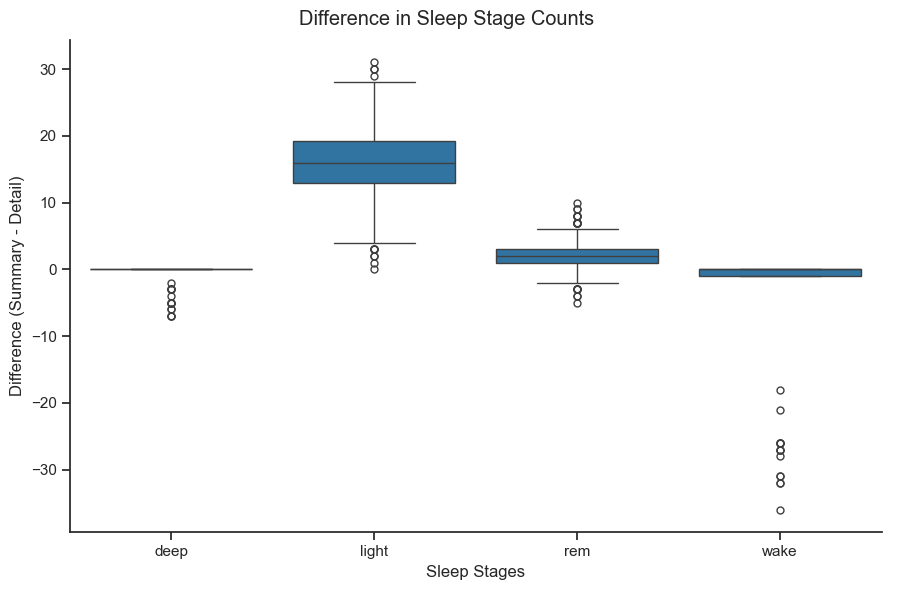

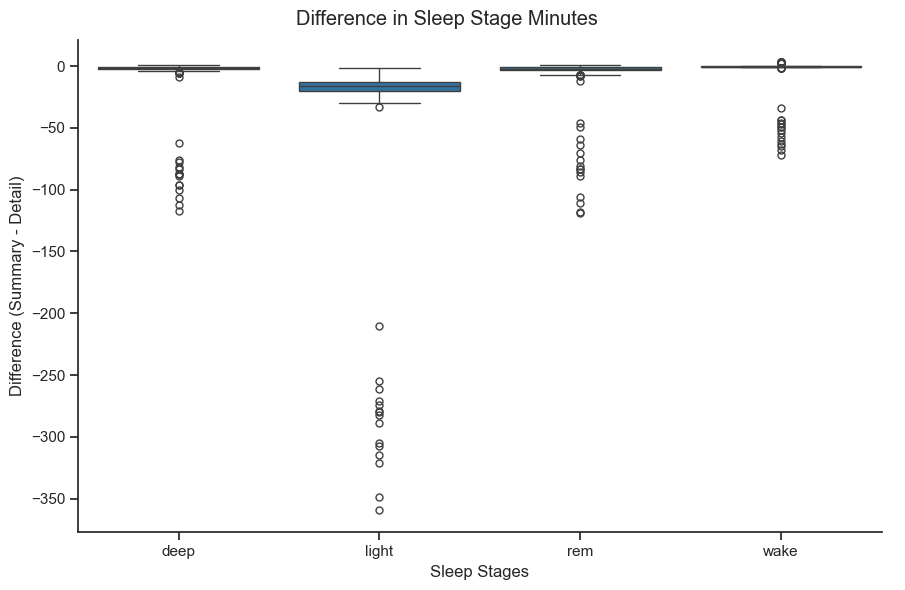

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("notebook")
g = sns.catplot(data=sleep_data_diff,x="stage", y="summary_less_detail_count", kind="box", height=6, aspect=1.5)
g.set_axis_labels("Sleep Stages", "Difference (Summary - Detail)")
g.fig.suptitle('Difference in Sleep Stage Counts')
g.fig.subplots_adjust(top=.93)
plt.show()
g = sns.catplot(data=sleep_data_diff,x="stage", y="summary_less_detail_minutes", kind="box", height=6, aspect=1.5)
g.set_axis_labels("Sleep Stages", "Difference (Summary - Detail)")
g.fig.suptitle('Difference in Sleep Stage Minutes')
g.fig.subplots_adjust(top=.93)
plt.show()

It's clear with these 2 plots that our data doesn't really agree for *light* sleep stages, *deep* & *wake*, seem tolerable and *rem* is okay. That's all we need to know, I figured I'd break up the monotony of text, code, & data with a plot or 2. Now onto other datasets.

## Heart Rate & HRV
We are going to be moving a little faster here so what we want to do is bring in the heart rate data. Both the actual measures of heart rate and then the heart rate variability data. The ***heart rate data*** is in a json format, which has a **bpm** and **confidence** measure for each timestamp. The **confidence** measure goes from 0 (no heart rate detected) to 3 (high confidence). The **dateTime** intervals seem to be irregular measures between 5 and 10 seconds. The ***HRV Data*** is a CSV and is a summary set of data that is gathered once a day, it represents the numbers you see on your sleep metrics for the Heart Rate Variability. There are other more frequent measures of HRV but it's not clear how they get this summary number from those so I'm sticking with the summary. The **rmssd** is the field that we are after for HRV and it's important to note that it takes this measure during sleep and will report it essentially after you wake up, but it gets assigned to that date too. For example if I start sleep on 2024-12-22 at 22:00:00 and wake up on 2024-12-23 at 06:00:00, my HRV score will be measured during sleep and assigned with the 2024-12-23 date. 

## Establishing The Right Dataset for Predictions
It is extremely important to understand if my goal is to create a dataset to predict HRV, I want to make this as realistic as possible so using my example date above, I should be taking data from the day of 2024-12-22 to predict the HRV I was assigned on 2024-12-23. Also if I truly wanted to make this a good quality model, I would also want to make sure I do not take any data while I am sleeping, that's kind of like cheating. I want to be able to predict something BEFORE it happens not during the event where it's being measured. In order to make this a strong model I am going to filter my data to 2 hours before I fall asleep, this way someone could actually go get FitBit data from Google, download it and insert it into the model to make a prediction for the HRV score. This also means a lot of data wrangling and filtering which is why I chose DuckDB as I know how to manipulate data a lot easier with SQL than I do with Pandas.

In [14]:
heart_rate_data = duckdb.read_json('./data/unzipped/Takeout/Fitbit/Global Export Data/heart_rate-*.json', timestamp_format="%m/%d/%y %H:%M:%S")
heart_rate_df = duckdb.sql('select dateTime, unnest(value) from heart_rate_data').df()
display(heart_rate_df.head(10))

hrv_df = duckdb.read_csv('./data/unzipped/Takeout/Fitbit/Heart Rate Variability/Daily Heart Rate Variability Summary*.csv', timestamp_format="%Y-%m-%dT%H:%M:%S").df()
display(hrv_df.sort_values('timestamp').head(10))

,dateTime,bpm,confidence
0,2023-08-12 18:36:31,70,0
1,2023-08-12 18:36:46,64,0
2,2023-08-12 18:36:51,63,1
3,2023-08-12 18:36:56,65,1
4,2023-08-12 18:37:01,72,1
5,2023-08-12 18:37:06,76,1
6,2023-08-12 18:37:16,74,2
7,2023-08-12 18:37:21,73,2
8,2023-08-12 18:37:31,71,1
9,2023-08-12 18:37:36,70,1


,timestamp,rmssd,nremhr,entropy
0,2023-08-13,48.934,60.798,2.855
125,2023-08-14,40.485,67.520,2.632
364,2023-08-15,51.453,58.189,2.803
17,2023-08-16,37.462,64.676,2.446
336,2023-08-17,53.514,60.341,2.801
304,2023-08-18,48.468,62.162,2.742
394,2023-08-19,52.700,56.938,2.955
14,2023-08-20,54.221,61.383,3.103
2,2023-08-21,65.983,54.468,2.953
3,2023-08-22,50.733,57.393,2.787


In order to prepare the sleep summary data I am going to have to pivot it from a long format (multiple rows per observation) to a wide format (1 row per observation). There are a number of ways to do this in both DuckDB and Pandas. I am going to show you how to produce the same dataset by using *pivot* functions and then time the performance of both. Note that pandas is faster but in my opinion DuckDB is more readable. I only have the data that I have which is ~1800 rows. Perhaps if there was a lot more data DuckDB would be faster...perhaps not, all I can tell you is that not everything will be faster with DuckDB.

In [15]:
%%timeit
adj_sleep_summary_pandas_df = sleep_summary_df[['logId','stage','count','minutes','thirtyDayAvgMinutes']].pivot(index='logId', columns='stage')
adj_sleep_summary_pandas_df.columns = [f"{col[1]}_{col[0]}" for col in adj_sleep_summary_pandas_df.columns]

# Reset index for a regular looking DataFrame
adj_sleep_summary_pandas_df.reset_index(inplace=True)

1.32 ms ± 45 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%%timeit
adj_sleep_summary_duck_df = duckdb.sql("""pivot sleep_summary on stage 
    using 
        first(count) as count, 
        first(minutes) as minutes, 
        first(thirtyDayAvgMinutes) as thirtyDayAvgMinutes 
    order by logId""")

423 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
adj_sleep_summary_df = duckdb.sql("""pivot sleep_summary on stage 
    using 
        first(count) as count, 
        first(minutes) as minutes, 
        first(thirtyDayAvgMinutes) as thirtyDayAvgMinutes 
    order by logId""").df()
display(adj_sleep_summary_df.head(10))

,logId,deep_count,deep_minutes,deep_thirtyDayAvgMinutes,light_count,light_minutes,light_thirtyDayAvgMinutes,rem_count,rem_minutes,rem_thirtyDayAvgMinutes,wake_count,wake_minutes,wake_thirtyDayAvgMinutes
0,42400922920,3.0,66.0,0.0,30.0,272.0,0.0,7.0,78.0,0.0,28.0,42.0,0.0
1,42412586924,4.0,86.0,66.0,29.0,218.0,272.0,7.0,87.0,78.0,26.0,34.0,42.0
2,42424336860,2.0,58.0,76.0,30.0,260.0,245.0,7.0,93.0,83.0,31.0,54.0,38.0
3,42437088181,4.0,128.0,70.0,28.0,204.0,250.0,7.0,72.0,86.0,24.0,51.0,43.0
4,42449293365,5.0,87.0,85.0,23.0,228.0,239.0,9.0,70.0,83.0,27.0,51.0,45.0
5,42463261545,5.0,93.0,85.0,31.0,265.0,236.0,12.0,81.0,80.0,32.0,34.0,46.0
6,42476649087,4.0,47.0,86.0,34.0,284.0,241.0,10.0,82.0,80.0,35.0,42.0,44.0
7,42487823141,4.0,77.0,81.0,30.0,276.0,247.0,7.0,75.0,80.0,29.0,47.0,44.0
8,42498649806,4.0,77.0,80.0,27.0,242.0,251.0,6.0,105.0,80.0,27.0,39.0,44.0
9,42510611886,5.0,87.0,80.0,27.0,222.0,250.0,6.0,86.0,83.0,28.0,42.0,44.0


## 

In [18]:
print(adj_sleep_summary_df.shape[0])
print(sleep_meta_df.shape[0])

466
465


In [19]:
complete_sleep_data = sleep_meta_df.merge(adj_sleep_summary_df, on='logId').sort_values('dateOfSleep')
display(complete_sleep_data.tail(5))

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,...,deep_thirtyDayAvgMinutes,light_count,light_minutes,light_thirtyDayAvgMinutes,rem_count,rem_minutes,rem_thirtyDayAvgMinutes,wake_count,wake_minutes,wake_thirtyDayAvgMinutes
71,47560780256,2024-11-23,2024-11-23 00:19:00,2024-11-23 07:32:30,25980000,0,379,54,0,433,...,71.0,22.0,279.0,270.0,7.0,48.0,70.0,23.0,54.0,52.0
423,47568889247,2024-11-24,2024-11-23 22:22:00,2024-11-24 07:31:30,32940000,0,488,61,0,549,...,70.0,38.0,314.0,270.0,7.0,75.0,69.0,35.0,61.0,52.0
376,47578085269,2024-11-25,2024-11-24 22:42:30,2024-11-25 05:45:30,25380000,0,372,51,0,423,...,71.0,19.0,233.0,272.0,5.0,64.0,69.0,20.0,51.0,52.0
375,47589819717,2024-11-26,2024-11-25 22:29:30,2024-11-26 06:44:30,29700000,0,457,38,0,495,...,72.0,21.0,262.0,271.0,7.0,104.0,69.0,23.0,38.0,52.0
70,47599022157,2024-11-27,2024-11-26 22:39:00,2024-11-27 04:01:30,19320000,0,290,32,0,322,...,72.0,14.0,202.0,270.0,2.0,39.0,70.0,13.0,32.0,51.0


If you're wondering why I didn't just use the SQL syntax below...I was just being lazy, with pandas if you use a merge (effectively an inner join), if you have the same name for the ***on*** column, it won't be repeated in the dataset. I could either write the SQL join and type out all the column names except for the second **logID** column or I could just use pandas, so I used pandas.

In [20]:
complete_sleep_data = sleep_meta_df.merge(adj_sleep_summary_df, on='logId').sort_values('dateOfSleep')
display(complete_sleep_data.tail(5))

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,...,deep_thirtyDayAvgMinutes,light_count,light_minutes,light_thirtyDayAvgMinutes,rem_count,rem_minutes,rem_thirtyDayAvgMinutes,wake_count,wake_minutes,wake_thirtyDayAvgMinutes
71,47560780256,2024-11-23,2024-11-23 00:19:00,2024-11-23 07:32:30,25980000,0,379,54,0,433,...,71.0,22.0,279.0,270.0,7.0,48.0,70.0,23.0,54.0,52.0
423,47568889247,2024-11-24,2024-11-23 22:22:00,2024-11-24 07:31:30,32940000,0,488,61,0,549,...,70.0,38.0,314.0,270.0,7.0,75.0,69.0,35.0,61.0,52.0
376,47578085269,2024-11-25,2024-11-24 22:42:30,2024-11-25 05:45:30,25380000,0,372,51,0,423,...,71.0,19.0,233.0,272.0,5.0,64.0,69.0,20.0,51.0,52.0
375,47589819717,2024-11-26,2024-11-25 22:29:30,2024-11-26 06:44:30,29700000,0,457,38,0,495,...,72.0,21.0,262.0,271.0,7.0,104.0,69.0,23.0,38.0,52.0
70,47599022157,2024-11-27,2024-11-26 22:39:00,2024-11-27 04:01:30,19320000,0,290,32,0,322,...,72.0,14.0,202.0,270.0,2.0,39.0,70.0,13.0,32.0,51.0


## Final Aggregation
Here is the final manipulation of the data where I am trying to establish the right dataset for a practical predictive model. I am using CTEs, the first is based on the sleep data which is essentially 1 record per day. I use the sleep data to establish the proper dates and times. I am using the **startTime** less 2 hours to the next row's **startTime** less 2 hours. From a temporal perspective the data starts 2 hours before I sleep, continues through my sleep and ends 2 hours before I fall asleep the next day. The **dateOfSleep** field records the date you woke up, so I want to predict the NEXT days HRV which is measured and computed during that sleeping interval. All of the heart rate data I want to use and aggregate is set by those start times which you can see in the second CTE, which is basically a cross join but where the heart rate is between the 2 start times established by the sleep data. The third and final CTE is used to aggregate that data so we have 1 record per sleep, so what we do is take measures using *max*, *min*, *std dev*, *median*, *10th percentile*, *90th percentile*, and the count of my bpm data, along with all the data from the sleeping records. Also just to see from a temporal perspective how well the previous HRV predicts the next days HRV I include that as a feature in the final query.  

In [21]:
final_df = duckdb.sql("""WITH Complete_Sleep AS (
                select *, 
                    (dateOfSleep::Date + 1) as hrv_prediction_date, 
                    (startTime - Interval '2 Hours') as startTime_sleep_less_2_hrs, 
                    ((lead(startTime) over (order by logId)) - Interval '2 Hours') as tomorrow_startTime_sleep_less_2_hrs 
                from complete_sleep_data),
            HR_with_sleep AS (   
                Select hr.*, cs.* from Complete_Sleep cs, heart_rate_df hr 
                where hr.dateTime >= cs.startTime_sleep_less_2_hrs 
                and hr.dateTime < tomorrow_startTime_sleep_less_2_hrs),
            hr_sleep_agg AS (
                Select dateOfSleep::date as dateOfSleep, hrv_prediction_date, 
                max(bpm) as bpm_max, min(bpm) as bpm_min, round(avg(bpm), 2) as bpm_avg, round(stddev_samp(bpm), 2) as bpm_std, 
                round(median(bpm),2) as bpm_median, round(quantile_cont(bpm, 0.10),2) as bpm_10th, round(quantile_cont(bpm, 0.90),2) as bpm_90th, 
                count(bpm) as bpm_count, minutesAsleep,
                minutesAwake,
                timeInBed,
                deep_count,
                light_count,
                rem_count,
                wake_count,
                deep_minutes,
                light_minutes,
                rem_minutes,
                wake_minutes,
                deep_thirtyDayAvgMinutes,
                light_thirtyDayAvgMinutes,
                rem_thirtyDayAvgMinutes,
                wake_thirtyDayAvgMinutes
            from HR_with_sleep
            Group by dateOfSleep::date, hrv_prediction_date, minutesAsleep, minutesAwake, 
                timeInBed,
                deep_count,
                light_count,
                rem_count,
                wake_count,
                deep_minutes,
                light_minutes,
                rem_minutes,
                wake_minutes,
                deep_thirtyDayAvgMinutes,
                light_thirtyDayAvgMinutes,
                rem_thirtyDayAvgMinutes,
                wake_thirtyDayAvgMinutes
            )
        select agg.*, lag(rmssd) over (order by dateOfSleep) as prev_hrv, hrv.rmssd as target_hrv from hr_sleep_agg agg inner join hrv_df hrv on agg.hrv_prediction_date = hrv.timestamp Order by dateOfSleep
           """).df()

In [22]:
pd.set_option('display.max_columns', None)
final_df.drop("hrv_prediction_date", axis=1, inplace=True)
display(final_df)

,dateOfSleep,bpm_max,bpm_min,bpm_avg,bpm_std,bpm_median,bpm_10th,bpm_90th,bpm_count,minutesAsleep,minutesAwake,timeInBed,deep_count,light_count,rem_count,wake_count,deep_minutes,light_minutes,rem_minutes,wake_minutes,deep_thirtyDayAvgMinutes,light_thirtyDayAvgMinutes,rem_thirtyDayAvgMinutes,wake_thirtyDayAvgMinutes,prev_hrv,target_hrv
0,2023-08-13,141,49,75.77,14.87,75.0,59.0,96.0,11070,416,42,458,3.0,30.0,7.0,28.0,66.0,272.0,78.0,42.0,0.0,0.0,0.0,0.0,NaN,40.485
1,2023-08-14,121,50,80.37,12.20,82.0,64.0,95.0,10169,391,34,425,4.0,29.0,7.0,26.0,86.0,218.0,87.0,34.0,66.0,272.0,78.0,42.0,40.485,51.453
2,2023-08-15,168,49,79.51,21.67,77.0,57.0,105.0,10797,411,54,465,2.0,30.0,7.0,31.0,58.0,260.0,93.0,54.0,76.0,245.0,83.0,38.0,51.453,37.462
3,2023-08-16,140,49,82.52,16.05,84.0,61.0,103.0,10225,404,51,455,4.0,28.0,7.0,24.0,128.0,204.0,72.0,51.0,70.0,250.0,86.0,43.0,37.462,53.514
4,2023-08-17,119,51,73.48,11.42,75.0,58.0,87.0,10522,385,51,436,5.0,23.0,9.0,27.0,87.0,228.0,70.0,51.0,85.0,239.0,83.0,45.0,53.514,48.468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2024-11-21,122,48,72.00,13.56,73.0,55.0,88.0,10101,379,50,429,3.0,20.0,5.0,19.0,79.0,248.0,52.0,50.0,71.0,273.0,71.0,51.0,51.494,42.113
450,2024-11-22,161,53,82.70,21.17,79.0,59.0,115.0,11472,364,56,420,4.0,23.0,3.0,20.0,62.0,237.0,65.0,56.0,72.0,272.0,70.0,51.0,42.113,44.060
451,2024-11-23,105,51,71.38,11.18,71.0,58.0,86.0,9222,379,54,433,3.0,22.0,7.0,23.0,52.0,279.0,48.0,54.0,71.0,270.0,70.0,52.0,44.060,58.188
452,2024-11-24,165,46,78.99,29.02,68.0,52.0,129.0,12668,488,61,549,5.0,38.0,7.0,35.0,99.0,314.0,75.0,61.0,70.0,270.0,69.0,52.0,58.188,60.853


## Bonus: Correlation Filtering
When you're preparing data for a model you generally want to exclude data that is highly correlated. "Highly" correlated is ambiguous so I'm going to use 0.9 as a threshold. You can do this with code automatically but I chose the manual approach to show you. I also show both the correlation matrix and a plot, it's much easier to just see the data and find the correlations than it is to read a square matrix of numbers. 

In [23]:
final_df.corr()  


,dateOfSleep,bpm_max,bpm_min,bpm_avg,bpm_std,bpm_median,bpm_10th,bpm_90th,bpm_count,minutesAsleep,minutesAwake,timeInBed,deep_count,light_count,rem_count,wake_count,deep_minutes,light_minutes,rem_minutes,wake_minutes,deep_thirtyDayAvgMinutes,light_thirtyDayAvgMinutes,rem_thirtyDayAvgMinutes,wake_thirtyDayAvgMinutes,prev_hrv,target_hrv
dateOfSleep,1.000000,-0.034703,-0.222612,-0.233377,0.039252,-0.342522,-0.300051,0.006009,-0.012505,0.019802,0.038499,0.026381,-0.113175,-0.071701,-0.182631,-0.136110,-0.116257,0.128219,-0.052281,0.044509,-0.092159,0.222209,-0.046121,0.186204,0.025463,0.025688
bpm_max,-0.034703,1.000000,-0.032256,0.616479,0.862258,0.174308,0.002621,0.770030,0.392694,0.019281,-0.111518,-0.007233,-0.039884,0.037702,0.017710,0.069070,0.040020,-0.014968,0.066116,-0.101243,0.011244,-0.048390,-0.021180,-0.026494,0.027929,-0.294057
bpm_min,-0.222612,-0.032256,1.000000,0.435690,-0.222124,0.495046,0.852287,0.036941,-0.014583,-0.208599,-0.134464,-0.223246,-0.076466,-0.167459,0.161166,-0.096298,-0.019692,-0.317837,0.059835,-0.149808,0.110658,-0.204543,0.031532,-0.006736,-0.729785,-0.225867
bpm_avg,-0.233377,0.616479,0.435690,1.000000,0.601060,0.785332,0.551725,0.789406,0.358291,-0.230068,-0.129557,-0.244961,-0.105497,-0.130345,0.057375,-0.064391,0.029081,-0.262923,-0.002994,-0.101802,0.155230,-0.219024,0.031240,-0.053862,-0.402024,-0.318599
bpm_std,0.039252,0.862258,-0.222124,0.601060,1.000000,0.108387,-0.216658,0.911308,0.460249,0.081034,-0.017095,0.072211,-0.017979,0.111178,-0.025332,0.109687,0.042664,0.106530,0.034241,0.008633,-0.009105,0.015408,-0.009556,-0.036509,0.181155,-0.208096
bpm_median,-0.342522,0.174308,0.495046,0.785332,0.108387,1.000000,0.603565,0.315115,0.070436,-0.362392,-0.144526,-0.374562,-0.108674,-0.243340,0.002315,-0.175163,-0.025979,-0.369781,-0.082595,-0.124105,0.186094,-0.243644,0.029352,-0.037234,-0.393489,-0.217225
bpm_10th,-0.300051,0.002621,0.852287,0.551725,-0.216658,0.603565,1.000000,0.077574,0.025891,-0.215607,-0.126706,-0.229250,-0.073619,-0.177767,0.208387,-0.079483,0.065534,-0.370895,0.068026,-0.137978,0.185833,-0.296932,0.056902,-0.028147,-0.810916,-0.237110
bpm_90th,0.006009,0.770030,0.036941,0.789406,0.911308,0.315115,0.077574,1.000000,0.500103,-0.010050,-0.039130,-0.017987,-0.049728,0.044032,-0.005131,0.050090,0.041224,0.007787,0.015588,-0.009024,0.036697,-0.057919,-0.002272,-0.051236,-0.073119,-0.235557
bpm_count,-0.012505,0.392694,-0.014583,0.358291,0.460249,0.070436,0.025891,0.500103,1.000000,0.381207,0.169575,0.396812,0.104383,0.233793,0.115941,0.215900,0.237387,0.200950,0.180984,0.135607,-0.002358,-0.020538,-0.073252,0.011239,0.005807,-0.264832
minutesAsleep,0.019802,0.019281,-0.208599,-0.230068,0.081034,-0.362392,-0.215607,-0.010050,0.381207,1.000000,0.161908,0.976578,0.334886,0.605575,0.320341,0.583821,0.496881,0.682627,0.509290,0.118121,-0.006983,-0.025883,0.000271,-0.037440,0.116860,-0.101370


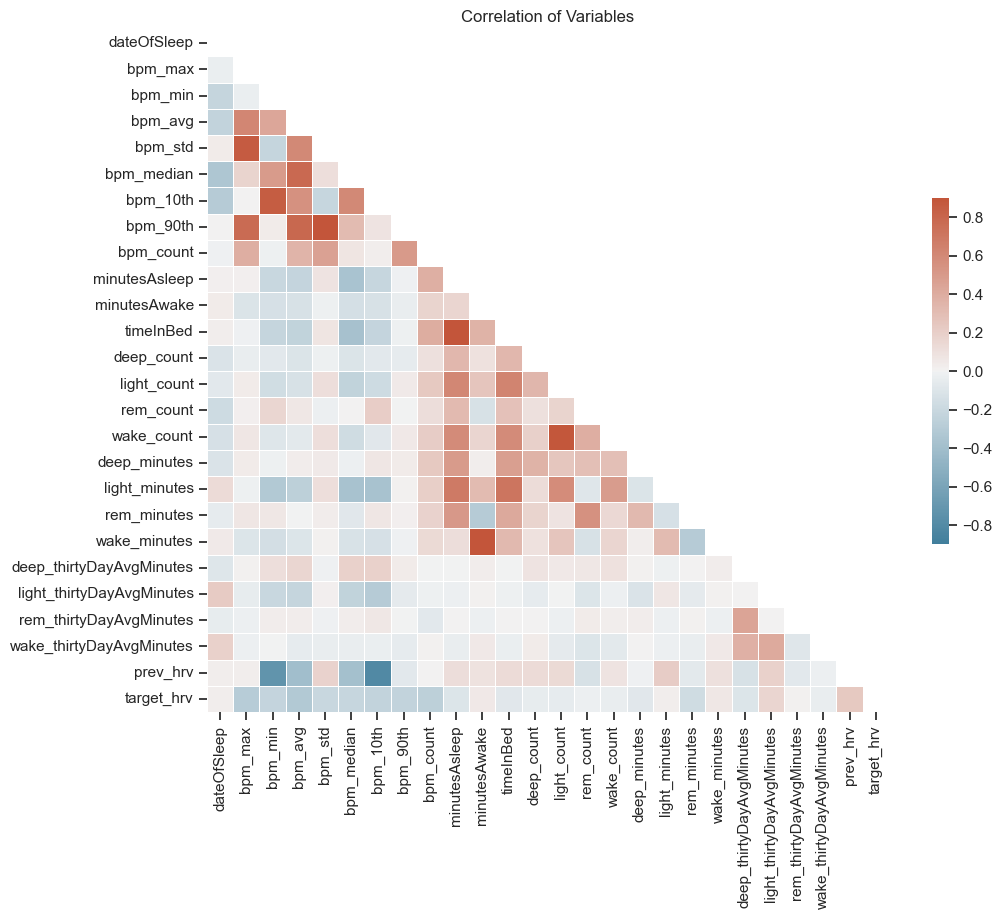

In [24]:
import numpy as np
corr = final_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.9, vmin=-0.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation of Variables')
plt.show()

Based on what I can see we have high (>= 0.90) correlation between a few different variables **wake_minutes** & **minutesAwake**, **timeInBed** & **minutesAsleep**, and **bpm_std** & **bpm_90th**. So I've decided to drop the **bpm_std**, **minutesAwake**, & **timeInBed** so the final filtered dataframe is below.

In [25]:
final_filt_df = final_df[['dateOfSleep', 'bpm_max', 'bpm_min', 'bpm_avg',
       'bpm_median', 'bpm_10th', 'bpm_90th', 'bpm_count',
       'minutesAsleep', 'deep_count',
       'light_count', 'rem_count', 'wake_count', 'deep_minutes',
       'light_minutes', 'rem_minutes', 'wake_minutes',
       'deep_thirtyDayAvgMinutes', 'light_thirtyDayAvgMinutes',
       'rem_thirtyDayAvgMinutes', 'wake_thirtyDayAvgMinutes', 'prev_hrv', 'target_hrv']]


## Conclusion
So we were able to use DuckDB to read in and manipulate json data, csv data, and dataframes with ease. We took the data we had with a goal in mind of being able to predict heart rate variability so we setup the data to do that and even filtered out highly correlated variables. Our data is now prepared for a machine learning model. Below I have put only the necessary code together to import and organize the data. I could probably make it more efficient but it runs in ~7 seconds to read in the sleep data, heart rate data, and heart rate variability data and manipulate it all to create our final dataset.

In [26]:
# organize it all
sleep_data = duckdb.read_json("./data/unzipped/Takeout/Fitbit/Global Export Data/sleep-*.json", timestamp_format="%Y-%m-%dT%H:%M:%S.%g")
sleep_meta_df = duckdb.sql("""Select distinct logId, dateOfSleep, startTime, endTime, duration, minutesToFallAsleep, minutesAsleep,
                            minutesAwake, minutesAfterWakeup, timeInBed, efficiency, type, infoCode, logType, mainSleep
                           FROM sleep_data
                           WHERE mainSleep == true""").df()
sleep_summary_df = duckdb.sql("""with summary_data as (select logId, unnest(levels.summary, max_depth := 1) from sleep_data),
      unioned_data as (
         select logId, 'deep' as stage, unnest(deep) from summary_data
         union all
         select logId, 'wake' as stage, unnest(wake) from summary_data
         union all
         select logId, 'light' as stage, unnest(light) from summary_data
         union all
         select logId, 'rem' as stage, unnest(rem) from summary_data)
      select logId, stage, count, minutes, max(thirtyDayAvgMinutes) as thirtyDayAvgMinutes
      from unioned_data
      group by logId, stage, count, minutes
      order by logId, stage""").df()
sleep_data_detail = duckdb.sql("""select logId, unnest(levels.data, recursive := True) from sleep_data order by logId""")
sleep_short_data = duckdb.sql("""select logId, unnest(levels.shortData, recursive := True) from sleep_data order by logId""")
heart_rate_data = duckdb.read_json('./data/unzipped/Takeout/Fitbit/Global Export Data/heart_rate-*.json', timestamp_format="%m/%d/%y %H:%M:%S")
heart_rate_df = duckdb.sql('select dateTime, unnest(value) from heart_rate_data').df()
hrv_df = duckdb.read_csv('./data/unzipped/Takeout/Fitbit/Heart Rate Variability/Daily Heart Rate Variability Summary*.csv', timestamp_format="%Y-%m-%dT%H:%M:%S").df()
adj_sleep_summary_df = duckdb.sql("""pivot sleep_summary_df on stage 
    using 
        first(count) as count, 
        first(minutes) as minutes, 
        first(thirtyDayAvgMinutes) as thirtyDayAvgMinutes 
    order by logId""").df()
complete_sleep_data = sleep_meta_df.merge(adj_sleep_summary_df, on='logId').sort_values('dateOfSleep')
final_df = duckdb.sql("""WITH Complete_Sleep AS (
                select *, 
                    (dateOfSleep::Date + 1) as hrv_prediction_date, 
                    (startTime - Interval '2 Hours') as startTime_sleep_less_2_hrs, 
                    ((lead(startTime) over (order by logId)) - Interval '2 Hours') as tomorrow_startTime_sleep_less_2_hrs 
                from complete_sleep_data),
            HR_with_sleep AS (   
                Select hr.*, cs.* from Complete_Sleep cs, heart_rate_df hr 
                where hr.dateTime >= cs.startTime_sleep_less_2_hrs 
                and hr.dateTime < tomorrow_startTime_sleep_less_2_hrs),
            hr_sleep_agg AS (
                Select dateOfSleep::date as dateOfSleep, hrv_prediction_date, 
                max(bpm) as bpm_max, min(bpm) as bpm_min, round(avg(bpm), 2) as bpm_avg, round(stddev_samp(bpm), 2) as bpm_std, 
                round(median(bpm),2) as bpm_median, round(quantile_cont(bpm, 0.10),2) as bpm_10th, round(quantile_cont(bpm, 0.90),2) as bpm_90th, 
                count(bpm) as bpm_count, minutesAsleep,
                minutesAwake,
                timeInBed,
                deep_count,
                light_count,
                rem_count,
                wake_count,
                deep_minutes,
                light_minutes,
                rem_minutes,
                wake_minutes,
                deep_thirtyDayAvgMinutes,
                light_thirtyDayAvgMinutes,
                rem_thirtyDayAvgMinutes,
                wake_thirtyDayAvgMinutes
            from HR_with_sleep
            Group by dateOfSleep::date, hrv_prediction_date, minutesAsleep, minutesAwake, 
                timeInBed,
                deep_count,
                light_count,
                rem_count,
                wake_count,
                deep_minutes,
                light_minutes,
                rem_minutes,
                wake_minutes,
                deep_thirtyDayAvgMinutes,
                light_thirtyDayAvgMinutes,
                rem_thirtyDayAvgMinutes,
                wake_thirtyDayAvgMinutes
            )
        select agg.*, lag(rmssd) over (order by dateOfSleep) as prev_hrv, hrv.rmssd as target_hrv from hr_sleep_agg agg inner join hrv_df hrv on agg.hrv_prediction_date = hrv.timestamp Order by dateOfSleep
           """).df()

final_filt_df = final_df[['dateOfSleep', 'bpm_max', 'bpm_min', 'bpm_avg',
       'bpm_median', 'bpm_10th', 'bpm_90th', 'bpm_count',
       'minutesAsleep', 'deep_count',
       'light_count', 'rem_count', 'wake_count', 'deep_minutes',
       'light_minutes', 'rem_minutes', 'wake_minutes',
       'deep_thirtyDayAvgMinutes', 'light_thirtyDayAvgMinutes',
       'rem_thirtyDayAvgMinutes', 'wake_thirtyDayAvgMinutes', 'prev_hrv', 'target_hrv']]